<h2>Super Resolution</h2>
Converting 64x64 px images to 256x256px

In [155]:
#Imports block

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from sklearn.utils import shuffle

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

In [2]:
#Define input/output size for data generator
input_size = 64
output_size = 256

#path to save model
model_dir_path = 'd:\Data\Education\Python\RobotDreams\FinalTask\Data\Models\Model01'
#path to save model checkpoints
model_checkpoints_path = 'd:\Data\Education\Python\RobotDreams\FinalTask\Data\Models\ModelCheckpoints'

Database conisis from random photos from my phone and some free photos from the internet :D

In [4]:
#Loading data
path = 'd:\Data\Education\Python\RobotDreams\FinalTask\Data\Photos'
samples = os.listdir(path)
np.random.shuffle(samples)

#80% for train
train_data = samples[0:int(len(samples)*0.8)]
val_test_data = samples[int(len(samples)*0.8):len(samples)]

#10% for validation
validation_data = val_test_data[0:int(len(val_test_data)*0.5)]
#10% for test
test_data = val_test_data[int(len(val_test_data)*0.5):len(val_test_data)]

print("Samples count: ", len(samples))
print("Train samples: ", len(train_data))
print("Validation samples: ", len(validation_data))
print("Test samples: ", len(test_data))

Samples count:  450
Train samples:  360
Validation samples:  45
Test samples:  45


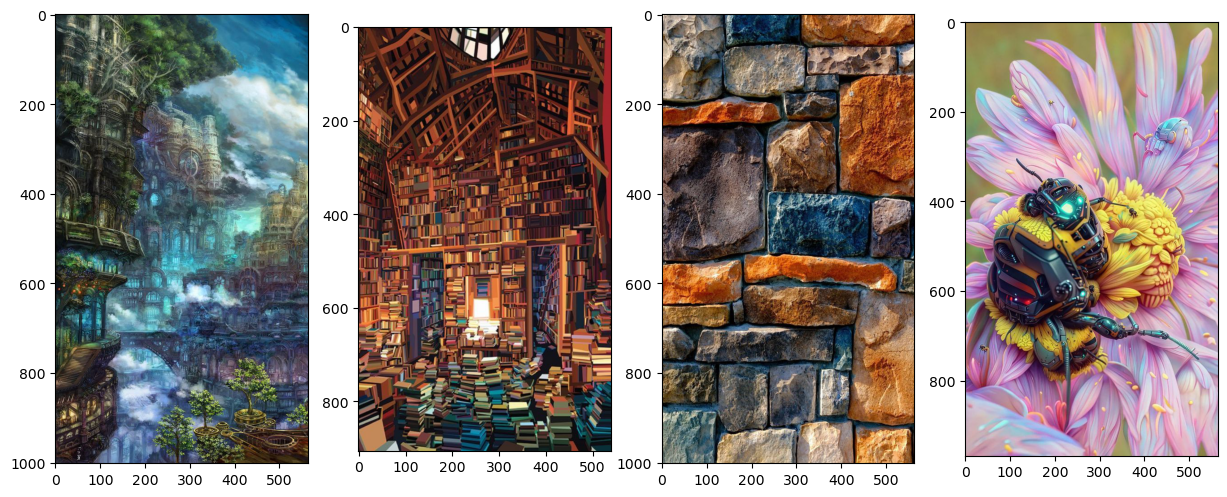

In [5]:
#Inspecting database
count = 4
for x in range(count):
    img = cv2.cvtColor(cv2.imread(os.path.join(path, np.random.choice(samples))), cv2.COLOR_BGR2RGB)
    plt.subplot(1,count,x+1), plt.imshow(img)

In [6]:
#Function to prepare data for data generator
#loads image from path
#does random 'output_size' crop -> stores in 'y'
#does downscale of 'y' to 'input_size' -> stores in 'x'
#makes data normalization

def PrepareData(item):
    #load image
    img = cv2.imread(os.path.join(path, item))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rows, cols, colors = img.shape
                
    #randomize crop position
    crop = [np.random.randint(rows - output_size),np.random.randint(cols - output_size)]
                
    #crop image
    img = img[crop[0]:crop[0]+output_size, crop[1]:crop[1]+output_size ]
                
    #normalize data
    img = img/255
    
    y = img
    x = cv2.resize(img, (input_size, input_size) )    
    return x, y

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1eaa3707550>)

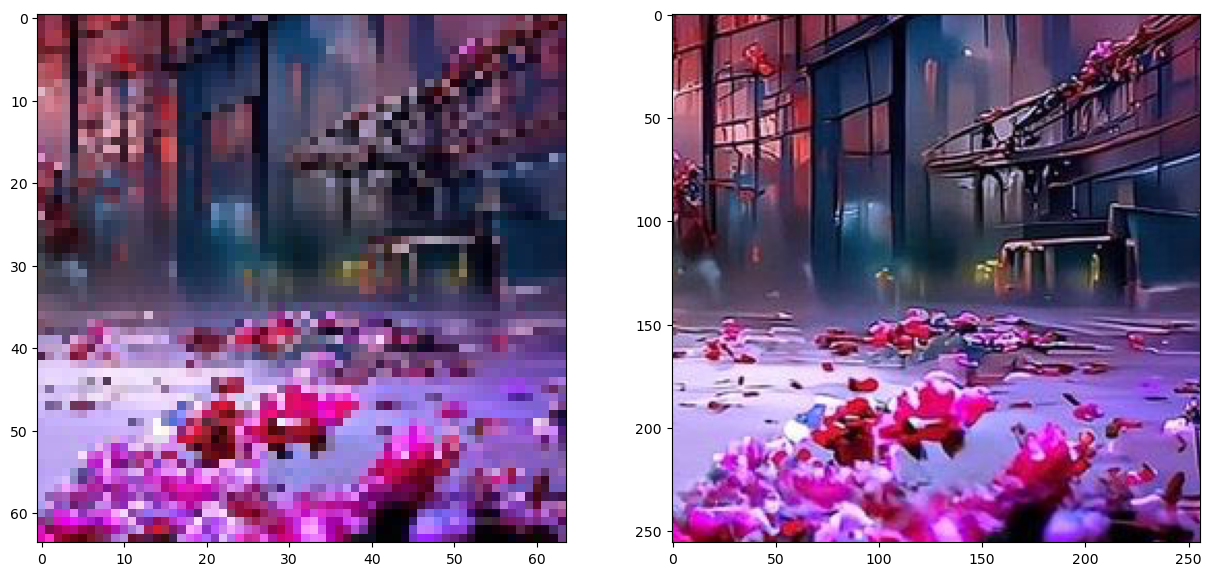

In [7]:
#check prepare data function
a,b = PrepareData(train_data[1])

plt.subplot(121), plt.imshow(a)
plt.subplot(122), plt.imshow(b)

In [16]:
#Building model
kernels_count = 64
residual_blocks = 4

def ResidualBlock(net, kernels, size):
    x = connect = net
    x = layers.Conv2D(kernels, size, padding="same", activation="relu")(x)
    x = layers.Conv2D(kernels, size, padding="same")(x)
    x = layers.Add()([x, connect])
    return x

def UpscaleBlock(net, kernels, size):
    x = layers.Conv2DTranspose(kernels, size, strides = 2, padding="same", activation="relu")(net)
    return x

#shall i use it? :D
def DownscaleBlock(net, kernels):
    x = layers.Conv2D(kernels, 3, strides = 2, padding="same", activation="relu")(net)
    return x

def GetModel(kernels_count):
    k = kernels_count
    
    inputs = layers.Input(shape = (None, None, 3) )
    
    x = layers.Conv2D(k, 5, padding="same", activation="relu")(inputs)
    
    for count in range(residual_blocks):
        x = ResidualBlock(x, k, 3)
    
    x = UpscaleBlock(x, k, 3)
    
    x = ResidualBlock(x, k, 3)
    
    x = UpscaleBlock(x, k, 3)
    
    outputs = layers.Conv2D(3, 1, strides = 1, padding="same", activation="sigmoid")(x)
    
    return Model(inputs, outputs) 


model = GetModel(kernels_count)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_10 (Conv2D)             (None, None, None,   4864        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_11 (Conv2D)             (None, None, None,   36928       ['conv2d_10[0][0]']              
                                64)                                                         

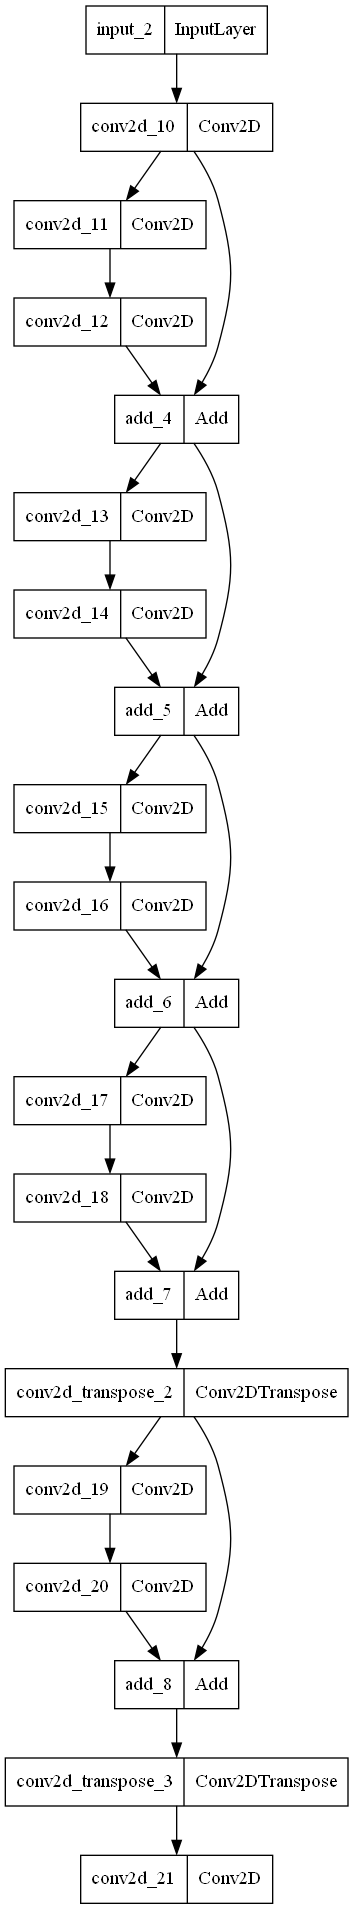

In [17]:
#visualize model graph
plot_model(model)#, show_shapes=True)

In [18]:
#Data generator
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import shuffle

class Generator(keras.utils.Sequence):    
    def __init__(self, batch_size, input_img_paths):
        self.batch_size = batch_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to **batch** index."""
        x_ = []
        y_ = []
        offset = idx*self.batch_size 
        batchPaths = self.input_img_paths[offset : offset+batch_size]
        
        for item in batchPaths:
            x, y = PrepareData(item)
            x_.append(x)
            y_.append(y)

        x_ = np.array(x_)
        y_ = np.array(y_)
            
        return x_, y_
    
    def on_epoch_end(self):
        self.input_img_paths = shuffle(self.input_img_paths)

In [19]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['PCNR'], '.-',
                               epochs, h['val_PCNR'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('PCNR')
    plt.legend(['Train', 'Validation'])
        
    print('Train PCNR     ', h['PCNR'][-1])
    print('Validation PCNR', h['val_PCNR'][-1])

In [20]:
#function to calculate PCNR metric
def PCNR(y_true, y_pred):
    pcnr = tf.image.psnr(
    y_true, y_pred, 1
)
    return pcnr

In [21]:
#training setup
batch_size = 32
epochs_count = 300

steps_epoch = len(train_data) // batch_size

train_gen = Generator(batch_size, train_data)
validation_gen = Generator(batch_size, validation_data)

print("Steps per epoch: ", steps_epoch)

Steps per epoch:  11


In [22]:
#compiling model
model.compile(loss="mae", optimizer="adam", metrics=["Accuracy", PCNR])

In [ ]:
#training
start = time()

history = model.fit(train_gen, steps_per_epoch=steps_epoch,
                    epochs=epochs_count, validation_data=validation_gen)

print('Elapsed time', time() - start)

In [ ]:
plot_history(history)

In [25]:
#create generator for test
test_gen = Generator(batch_size, test_data)

#evaluate model
pred_test = model.evaluate(test_gen)


1/1 [==============================] - 2s 2s/step - loss: 0.0496 - Accuracy: 0.9133 - PCNR: 22.8469


1/1 [==============================] - 1s 837ms/step


(<AxesSubplot:title={'center':'256x256 resized'}>,
 Text(0.5, 1.0, '256x256 resized'))

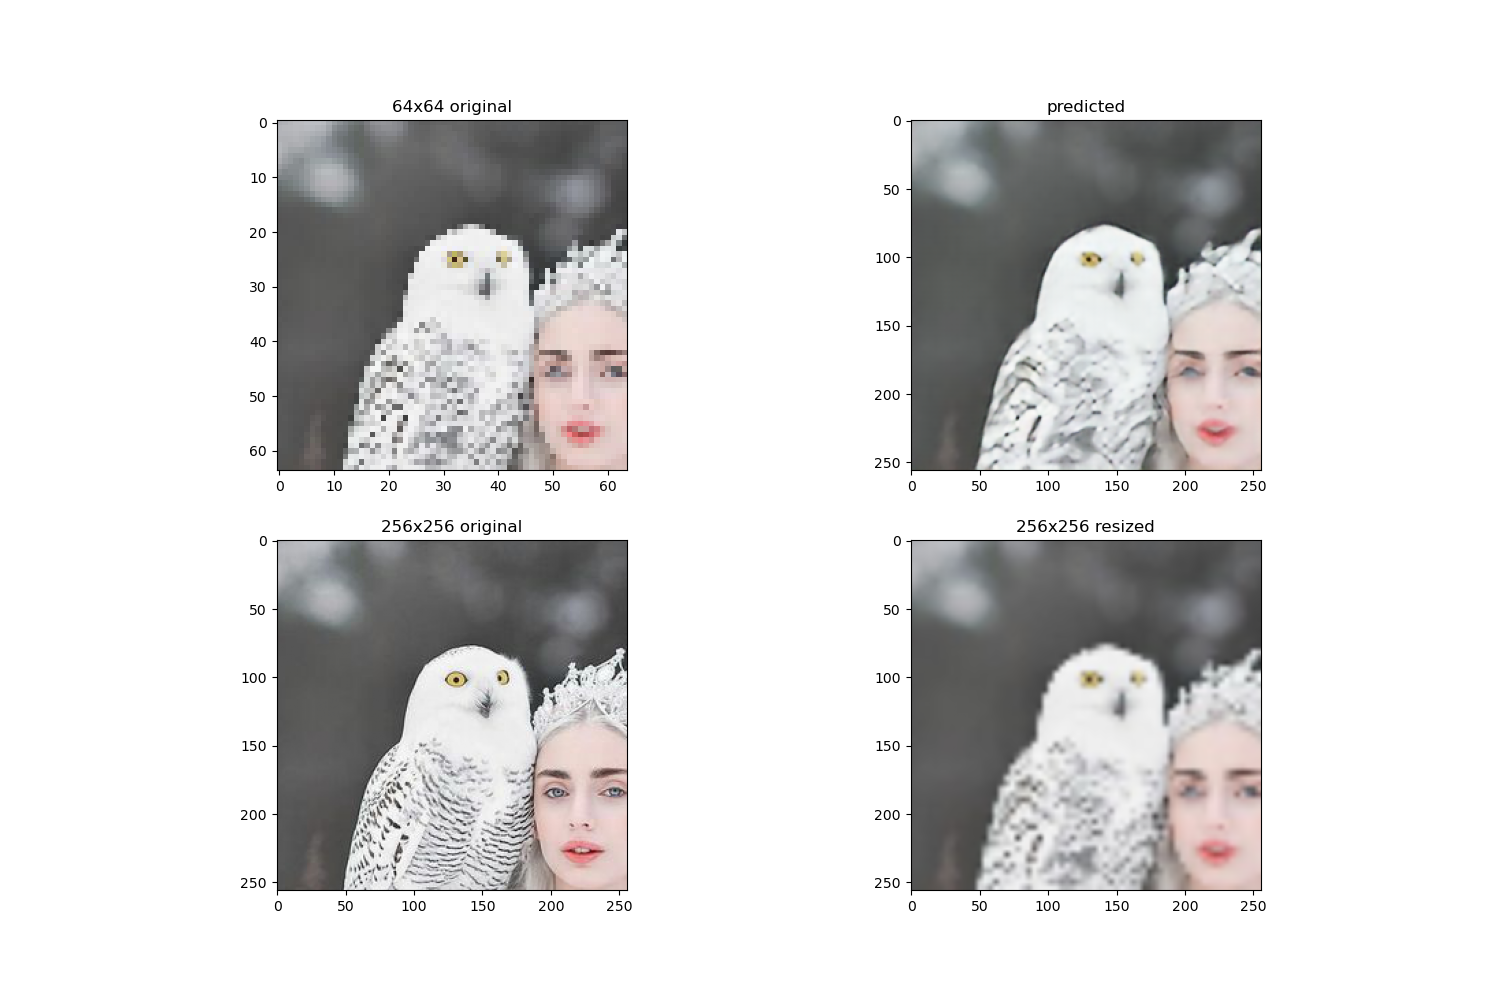

In [159]:
#output random prediction
x , y  = test_gen.__getitem__(0)
val_preds = model.predict(x)

idx = np.random.randint(0, len(val_preds))

plt.subplot(221), plt.imshow(x[idx]), plt.title("64x64 original")
plt.subplot(222), plt.imshow(val_preds[idx]), plt.title("predicted")
plt.subplot(223), plt.imshow(y[idx]), plt.title("256x256 original")
resized = cv2.resize(x[idx], (output_size, output_size) )    
plt.subplot(224), plt.imshow(resized), plt.title("256x256 resized")

In [63]:
print(x.shape)

(32, 64, 64, 3)


<h2>Thanks for viewing!</h2> ❤️️

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

Using this block to save model manually

In [33]:
model.Name = "test_model_02"
#path to save model
model_dir_path = 'd:\Data\Education\Python\RobotDreams\FinalTask\Data\Models\Model02'
tf.saved_model.save(model, model_dir_path)

INFO:tensorflow:Assets written to: d:\Data\Education\Python\RobotDreams\FinalTask\Data\Models\Model02\assets


INFO:tensorflow:Assets written to: d:\Data\Education\Python\RobotDreams\FinalTask\Data\Models\Model02\assets


<br><br><br><br><br><br><br><br><br><br><br>

Some usefull code other experiments...

In [ ]:
max_val = 1
psnr = tf.image.psnr(
    val_preds[idx], y[idx], max_val
)
print(psnr)

In [ ]:
#create callback for PSNR metrics
class PCNRMetricCallback(keras.callbacks.Callback):
    def __init__(self):
        super(PCNRMetricCallback, self).__init__()
        #x,y = PrepareData(validation_data[1])
        #self.lowres_img = x
        #self.highres_img = y

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("  Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        #if epoch % 20 == 0:
        #    prediction = upscale_image(self.model, self.test_img)
        #plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * np.log10(1 / logs["loss"]))

In [ ]:
#create callback to save model checkpoints
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

red channel


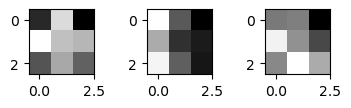

In [47]:

# retrieve weights from the second hidden layer
filters, biases = model.layers[2].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

print('red channel')
for i in range(len(filters)):
       plt.subplot(10,10,i+1), plt.imshow(filters[:,:,0,i], cmap='gray')




green channel


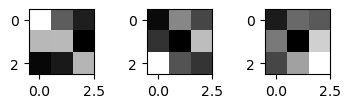

In [48]:
print('green channel')
for i in range(len(filters)):
       plt.subplot(10,10,i+1), plt.imshow(filters[:,:,1,i], cmap='gray')

blue channel


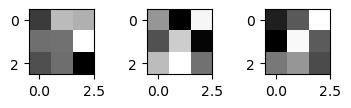

In [49]:
print('blue channel')
for i in range(len(filters)):
       plt.subplot(10,10,i+1), plt.imshow(filters[:,:,2,i], cmap='gray')

In [41]:
print(len(filters))

5


In [36]:
print(history)
history_bckp = history

1/1 [==============================] - 0s 33ms/step


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1ead91eca00>)

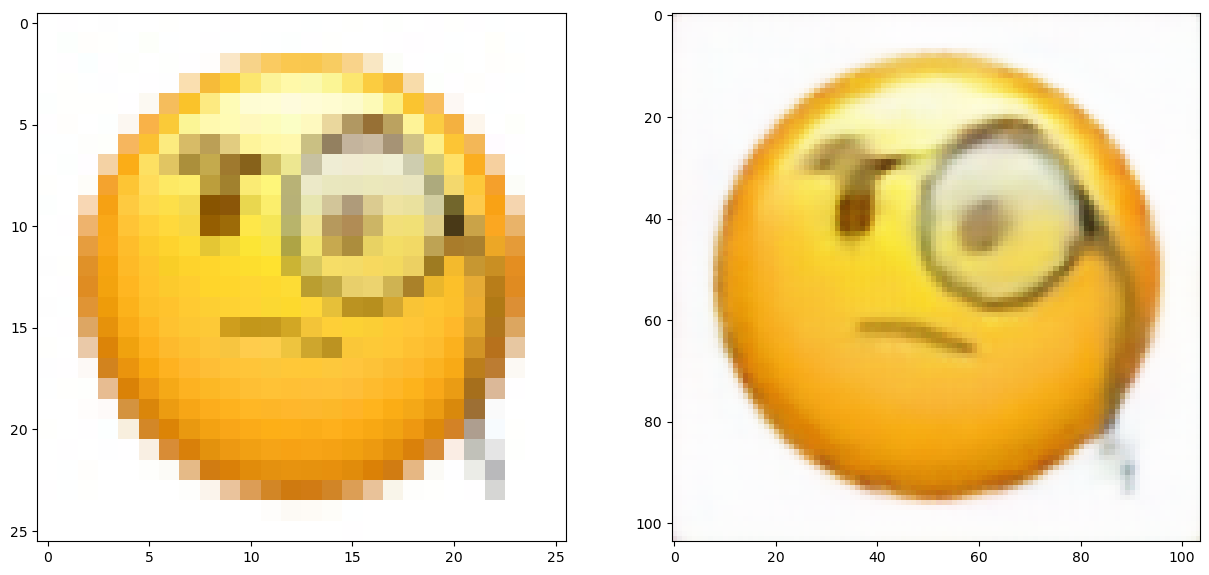

In [82]:
#smiles
smile_path = 'd:\Data\Education\Python\RobotDreams\FinalTask\Data\Presentation'
smile_name = 'ThinkingSmile.jpg'
#smile_lr = cv2.cvtColor( cv2.imread(smile_path), cv2.COLOR_BGR2RGB )
smile_lr = cv2.imread(os.path.join(smile_path, smile_name))
smile_lr = cv2.cvtColor(smile_lr, cv2.COLOR_BGR2RGB)

smile_lr = np.array([smile_lr])/255
smile_hr = model.predict(smile_lr)

plt.subplot(121), plt.imshow(smile_lr[0])
plt.subplot(122), plt.imshow(smile_hr[0])
#print(input.shape)

In [153]:
#smiles
im_path = 'd:\Data\Education\Python\RobotDreams\FinalTask\Data\Presentation'
im_name = '01LR.jpg'
im_bilinear_name = '01Bilinear.jpg'
im_predict_name = '01Predict.png'
#smile_lr = cv2.cvtColor( cv2.imread(smile_path), cv2.COLOR_BGR2RGB )
im_lr = cv2.imread(os.path.join(im_path, im_name))
im_lr = cv2.cvtColor(im_lr, cv2.COLOR_BGR2RGB)

im_lr = np.array([im_lr])/255
im_hr = model.predict(im_lr)

write = cv2.cvtColor(im_hr[0], cv2.COLOR_RGB2BGR)*255
cv2.imwrite(os.path.join(im_path, im_predict_name), write)
#plt.subplot(211), plt.imshow(im_lr[0])
#plt.subplot(212), plt.imshow(im_hr[0])
#print(input.shape)

1/1 [==============================] - 0s 448ms/step


True

In [146]:
def display_image_in_actual_size(im_path):

    dpi = 100
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

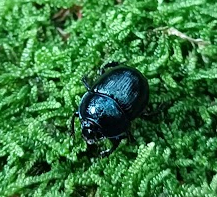

In [147]:
display_image_in_actual_size(os.path.join(im_path, im_name))

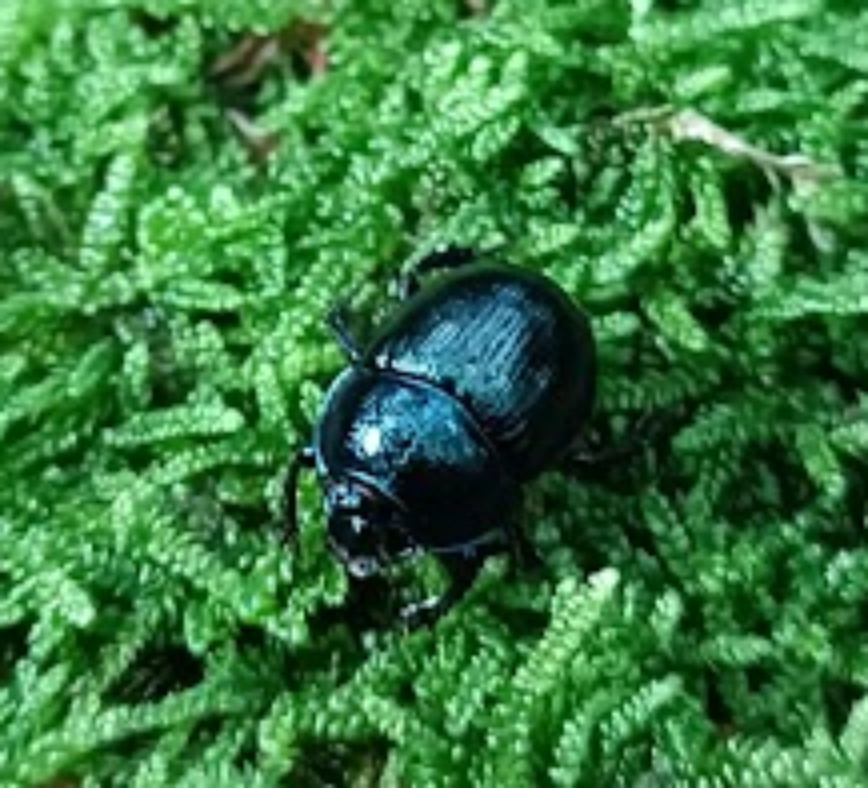

In [148]:
display_image_in_actual_size(os.path.join(im_path, im_bilinear_name))